# Integrator RNN Model

In this notebook, we train a vanilla RNN to integrate white noise. This example is useful on its own to understand how RNN training works.

In [1]:
import time
from functools import partial

In [2]:
import brainpy as bp
import brainpy.math as bm
bm.set_platform('cpu')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

## Parameters

In [4]:
# Integration parameters
T = 1.0  # Arbitrary amount time, roughly physiological.
dt = 0.04
num_step = int(T / dt)  # Divide T into this many bins
bval = 0.01  # bias value limit
sval = 0.025  # standard deviation (before dividing by sqrt(dt))

In [5]:
# The scaling of the recurrent parameters in an RNN really matters.
# The correct scaling is 1/sqrt(number of recurrent inputs), which
# yields an order 1 signal output to a neuron if the input is order 1.
# Given that VRNN uses a tanh nonlinearity, with min and max output
# values of -1 and 1, this works out.  The scaling just below 1
# (0.95) is because we know we are making a line attractor so, we
# might as well start it off basically right 1.0 is also basically
# right, but perhaps will lead to crazier dynamics.
param_scale = 0.85  # Scaling of the recurrent weight matrix

In [6]:
# Optimization hyperparameters
l2reg = 0.0002  # amount of L2 regularization on the weights
num_train = 10000  # Total number of batches to train on.
num_batch = 128  # How many examples in each batch
max_grad_norm = 5.0  # Gradient clipping is HUGELY important for training RNNs
                     # max gradient norm before clipping, clip to this value.

## Helpers

In [7]:
def plot_examples(num_time, inputs, hiddens, outputs, targets, num_example=1, num_plot=10):
  """Plot some input/hidden/output triplets."""
  plt.figure(figsize=(num_example * 5, 14))

  for bidx in range(num_example):
    plt.subplot(3, num_example, bidx + 1)
    plt.plot(inputs[:, bidx], 'k')
    plt.xlim([0, num_time])
    plt.title('Example %d' % bidx)
    if bidx == 0: plt.ylabel('Input Units')

  closeness = 0.25
  for bidx in range(num_example):
    plt.subplot(3, num_example, num_example + bidx + 1)
    plt.plot(hiddens[:, bidx, 0:num_plot] + closeness * np.arange(num_plot), 'b')
    plt.xlim([0, num_time])
    if bidx == 0: plt.ylabel('Hidden Units')

  for bidx in range(num_example):
    plt.subplot(3, num_example, 2 * num_example + bidx + 1)
    plt.plot(outputs[:, bidx, :], 'r', label='predict')
    plt.plot(targets[:, bidx, :], 'k', label='target')
    plt.xlim([0, num_time])
    plt.xlabel('Time steps')
    plt.legend()
    if bidx == 0: plt.ylabel('Output Units')

  plt.show()

In [8]:
def plot_params(rnn):
  """ Plot the parameters of the vanilla RNN. """
  assert isinstance(rnn, IntegratorRNN)

  plt.figure(figsize=(16, 8))
  plt.subplot(231)
  plt.stem(rnn.w_ro.numpy()[:, 0])
  plt.title('W_ro - output weights')

  plt.subplot(232)
  plt.stem(rnn.h0)
  plt.title('h0 - initial hidden state')

  plt.subplot(233)
  plt.imshow(rnn.w_rr.numpy(), interpolation=None)
  plt.colorbar()
  plt.title('W_rr - recurrent weights')

  plt.subplot(234)
  plt.stem(rnn.w_ir.numpy()[0, :])
  plt.title('W_ir - input weights')

  plt.subplot(235)
  plt.stem(rnn.b_rr.numpy())
  plt.title('b_rr - recurrent biases')

  plt.subplot(236)
  evals, _ = np.linalg.eig(rnn.w_rr.numpy())
  x = np.linspace(-1, 1, 1000)
  plt.plot(x, np.sqrt(1 - x ** 2), 'k')
  plt.plot(x, -np.sqrt(1 - x ** 2), 'k')
  plt.plot(np.real(evals), np.imag(evals), '.')
  plt.axis('equal')
  plt.title('Eigenvalues of W_rr')

  plt.show()

In [9]:
def plot_data(num_time, inputs, targets=None, outputs=None, errors=None, num_plot=10):
  """Plot some white noise / integrated white noise examples.

  Parameters
  ----------
  num_time : int
  num_plot : int
  inputs: ndarray
    with the shape of (num_batch, num_time, num_input)
  targets: ndarray
    with the shape of (num_batch, num_time, num_output)
  outputs: ndarray
    with the shape of (num_batch, num_time, num_output)
  errors: ndarray
    with the shape of (num_batch, num_time, num_output)
  """
  num = 1
  if errors is not None: num += 1
  if (targets is not None) or (outputs is not None): num += 1
  plt.figure(figsize=(14, 4 * num))

  # inputs
  plt.subplot(num, 1, 1)
  plt.plot(inputs[:, 0:num_plot, 0])
  plt.xlim([0, num_time - 1])
  plt.ylabel('Noise')

  legends = []
  if outputs is not None:
    plt.subplot(num, 1, 2)
    plt.plot(outputs[:, 0:num_plot, 0])
    plt.xlim([0, num_time - 1])
    legends.append(mlines.Line2D([], [], color='k', linestyle='-', label='predict'))
  if targets is not None:
    plt.subplot(num, 1, 2)
    plt.plot(targets[:, 0:num_plot, 0], '--')
    plt.xlim([0, num_time - 1])
    plt.ylabel("Integration")
    legends.append(mlines.Line2D([], [], color='k', linestyle='--', label='target'))
  if len(legends): plt.legend(handles=legends)

  if errors is not None:
    plt.subplot(num, 1, 3)
    plt.plot(errors[:, 0:num_plot, 0], '--')
    plt.xlim([0, num_time - 1])
    plt.ylabel("|Errors|")

  plt.xlabel('Time steps')
  plt.show()

In [10]:
@partial(bm.jit, dyn_vars=bp.TensorCollector({'a': bm.random.DEFAULT}))
def build_inputs_and_targets(mean, scale):
  """Build white noise input and integration targets."""

  # Create the white noise input.
  sample = bm.random.normal(size=(num_batch,))
  bias = mean * 2.0 * (sample - 0.5)
  samples = bm.random.normal(size=(num_step, num_batch))
  noise_t = scale / dt ** 0.5 * samples
  white_noise_t = bias + noise_t
  inputs_tx1 = bm.expand_dims(white_noise_t, axis=2)

  # * dt, intentionally left off to get output scaling in O(1).
  targets_tx1 = bm.expand_dims(bm.cumsum(white_noise_t, axis=0), axis=2)
  return inputs_tx1, targets_tx1

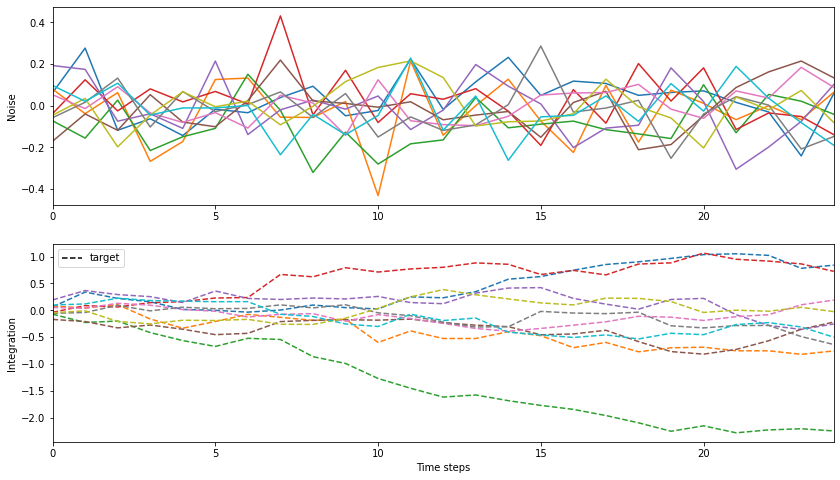

In [11]:
# Plot the example inputs and targets for the RNN.
_ints, _outs = build_inputs_and_targets(bval, sval)

plot_data(num_step, inputs=_ints, targets=_outs)

## Models

In [12]:
class IntegratorRNN(bp.DynamicalSystem):
  def __init__(self, num_input, num_hidden, num_output, num_batch,
               g=1.0, l2_reg=2e-4, **kwargs):
    super(IntegratorRNN, self).__init__(**kwargs)

    # parameters
    self.num_input = num_input
    self.num_hidden = num_hidden
    self.num_output = num_output
    self.num_batch = num_batch
    self.g = g
    self.l2_reg = l2_reg
    self.rng = bm.random.RandomState()

    # weights
    self.w_ir = bm.TrainVar(self.rng.normal(scale=1 / num_input ** 0.5, size=(num_input, num_hidden)))
    self.w_rr = bm.TrainVar(self.rng.normal(scale=g / num_hidden ** 0.5, size=(num_hidden, num_hidden)))
    self.b_rr = bm.TrainVar(bm.zeros((num_hidden,)))
    self.w_ro = bm.TrainVar(self.rng.normal(scale=1 / num_hidden ** 0.5, size=(num_hidden, num_output)))
    self.b_ro = bm.TrainVar(bm.zeros((num_output,)))
    self.h0 = bm.TrainVar(self.rng.normal(scale=0.1, size=(num_hidden, )))

    # variables
    self.h = bm.Variable(bm.repeat(bm.expand_dims(self.h0, 0), self.num_batch, axis=0))
    self.o = bm.Variable(self.h @ self.w_ro)
    self.total_loss = bm.Variable(bm.zeros(1))
    self.l2_loss = bm.Variable(bm.zeros(1))
    self.mse_loss = bm.Variable(bm.zeros(1))

  def update(self, x, **kwargs):
    self.h.value = bm.tanh(self.h @ self.w_rr + x @ self.w_ir + self.b_rr)
    self.o.value = self.h @ self.w_ro + self.b_ro
  
  def predict(self, xs):
    self.h[:] = self.h0
    scan = bm.make_loop(self.update, dyn_vars=self.vars().unique(), out_vars=[self.h, self.o])
    return scan(xs)

  def loss(self, inputs, targets):
    _, predicts = self.predict(inputs)
    l2 = self.l2_reg * bm.losses.l2_norm([self.w_ir, self.w_rr, self.b_rr,
                                          self.w_ro, self.b_ro, self.h]) ** 2
    mse = bm.losses.mean_squared_error(predicts, targets)
    total = l2 + mse
    self.total_loss[0] = total
    self.l2_loss[0] = l2
    self.mse_loss[0] = mse
    return total

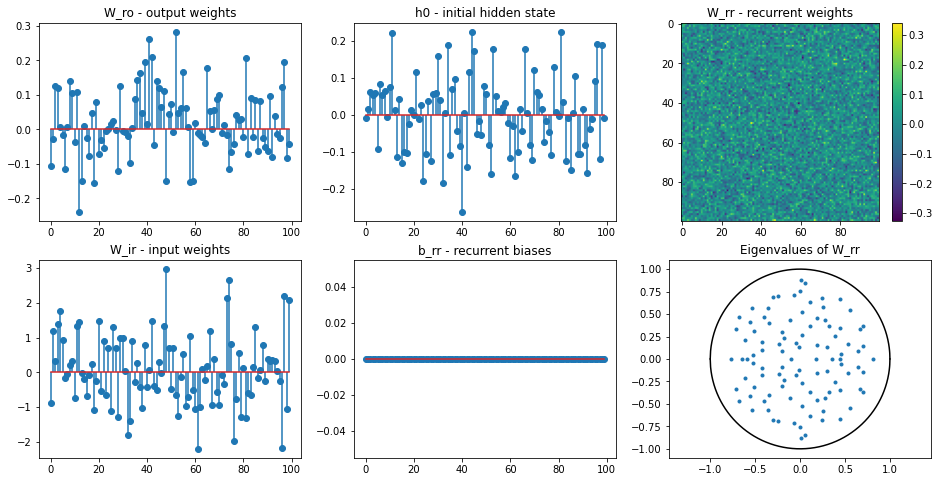

In [13]:
net = IntegratorRNN(num_input=1, num_hidden=100, num_output=1, num_batch=num_batch, 
                    g=param_scale, l2_reg=l2reg)

plot_params(net)

In [14]:
lr = bp.optim.ExponentialDecay(lr=0.025, decay_steps=1, decay_rate=0.99975)
optimizer = bp.optim.Adam(lr=lr, train_vars=net.train_vars(), eps=1e-1)
grad_f = bm.grad(net.loss, dyn_vars=net.vars(), grad_vars=net.train_vars(), return_value=True)


@bm.jit
@bm.function(nodes=(net, optimizer))
def train(inputs, targets):
  grads, loss =grad_f(inputs, targets)
  clipped_grads = bm.clip_by_norm(grads, max_grad_norm)
  optimizer.update(clipped_grads)
  return loss

## Training

In [15]:
t0 = time.time()
train_losses = {'total': [], 'l2': [], 'mse': []}
for i in range(num_train):
  _ins, _outs = build_inputs_and_targets(bval, sval)
  loss = train(inputs=_ins, targets=_outs)
  if (i + 1) % 100 == 0:
    print(f"Run batch {i} in {time.time() - t0:0.3f} s, learning rate: "
          f"{lr():.5f}, training loss {loss:0.4f}")

    train_losses['total'].append(net.total_loss[0])
    train_losses['l2'].append(net.l2_loss[0])
    train_losses['mse'].append(net.mse_loss[0])

Run batch 99 in 1.817 s, learning rate: 0.02438, training loss 0.1007
Run batch 199 in 2.464 s, learning rate: 0.02378, training loss 0.0957
Run batch 299 in 3.067 s, learning rate: 0.02319, training loss 0.0870
Run batch 399 in 3.678 s, learning rate: 0.02262, training loss 0.1056
Run batch 499 in 4.288 s, learning rate: 0.02206, training loss 0.0747
Run batch 599 in 4.882 s, learning rate: 0.02152, training loss 0.0738
Run batch 699 in 5.483 s, learning rate: 0.02099, training loss 0.0734
Run batch 799 in 6.074 s, learning rate: 0.02047, training loss 0.0761
Run batch 899 in 6.927 s, learning rate: 0.01996, training loss 0.0688
Run batch 999 in 7.521 s, learning rate: 0.01947, training loss 0.0723
Run batch 1099 in 8.111 s, learning rate: 0.01899, training loss 0.0773
Run batch 1199 in 8.699 s, learning rate: 0.01852, training loss 0.0713
Run batch 1299 in 9.286 s, learning rate: 0.01806, training loss 0.0637
Run batch 1399 in 9.873 s, learning rate: 0.01762, training loss 0.0583
Run

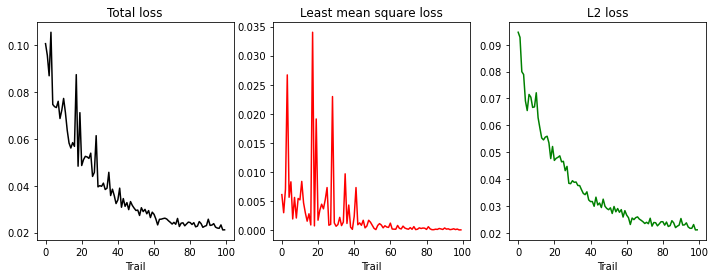

In [16]:
# Show the loss through training.
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.plot(train_losses['total'], 'k')
plt.title('Total loss')
plt.xlabel('Trail')

plt.subplot(132)
plt.plot(train_losses['mse'], 'r')
plt.title('Least mean square loss')
plt.xlabel('Trail')

plt.subplot(133)
plt.plot(train_losses['l2'], 'g')
plt.title('L2 loss')
plt.xlabel('Trail')
plt.show()

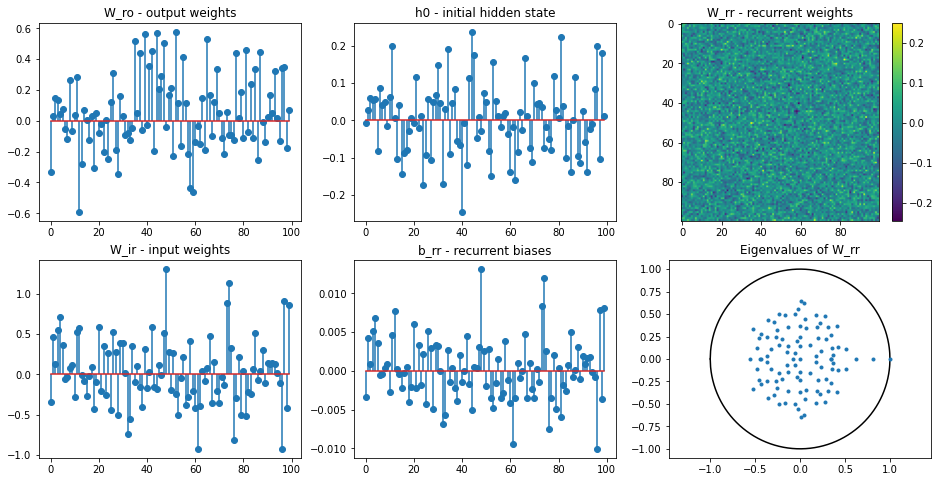

In [17]:
# Show the trained weights
plot_params(net)

## Testing

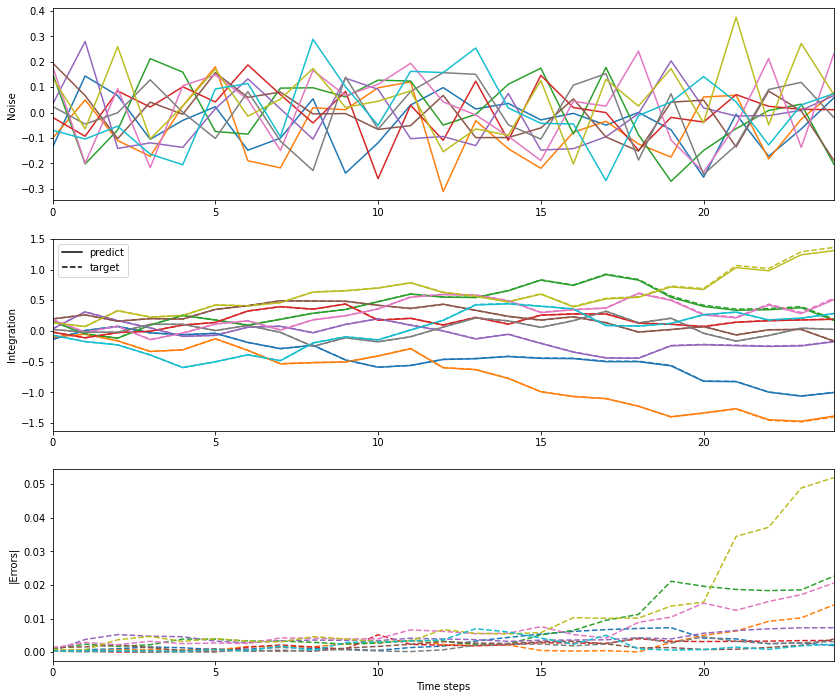

In [18]:
inputs, hiddens, outputs, targets = [], [], [], []
for n in range(16):
  input_b, target_b = build_inputs_and_targets(bval, sval)
  h_b, o_b = net.predict(input_b)
  inputs.append(input_b)
  hiddens.append(h_b)
  outputs.append(o_b)
  targets.append(target_b)
inputs = np.hstack(inputs)
hiddens = np.hstack(hiddens)
outputs = np.hstack(outputs)
targets = np.hstack(targets)

plot_data(num_step, inputs=inputs, targets=targets, outputs=outputs, errors=np.abs(targets - outputs))

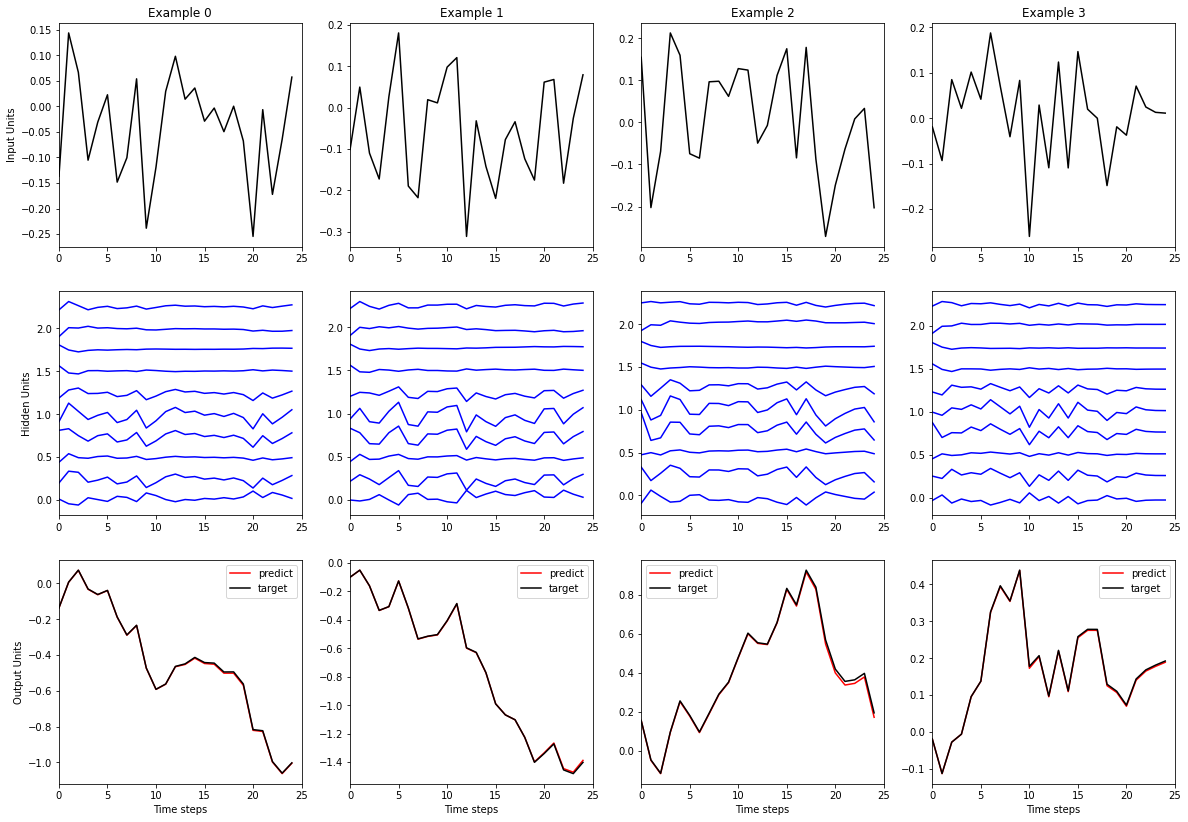

In [19]:
plot_examples(num_step, inputs=inputs, targets=targets, outputs=outputs, hiddens=hiddens, num_example=4)